In [26]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir = os.path.join(drive_dir, 'battery_experimental_data')
    fit_res_dir = os.path.join(drive_dir, 'fitting_results')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    fit_res_dir = os.path.abspath('fitting_results')
    
from tools import *

In [27]:
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
training_data_0 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_0.csv'))
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
training_data_40 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_40.csv'))

ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V
SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels
temp_from_idx_map = {0: '$0^oC$', 1: '$20^oC$', 2: '$40^oC$'}  # 3 temperature level


def pad_time(t, max_length):
    N = len(t)
    if N == max_length:
        return t
    interval = t[-1] - t[-2]
    padded_t = np.pad(t, (0, max_length - N), mode='constant', constant_values=(0))
    padded_t[N - max_length:] = np.arange(t[-1] + interval, t[-1] + (max_length-len(t)+1) * interval, interval)
    
    return padded_t

max_length = np.max([len(training_data_0), len(training_data_20), len(training_data_40)])
t = [pad_time(training_data_0['Time (s)'].values, max_length), 
     pad_time(training_data_20['Time (s)'].values, max_length), 
     pad_time(training_data_40['Time (s)'].values, max_length)]
I = [np.pad(training_data_0['Current (A)'], (0, max_length - len(training_data_0)), mode='edge'),
     np.pad(training_data_20['Current (A)'], (0, max_length - len(training_data_20)), mode='edge'),
     np.pad(training_data_40['Current (A)'], (0, max_length - len(training_data_40)), mode='edge')]
V_actual = [np.pad(training_data_0['Voltage (V)'], (0, max_length - len(training_data_0)), mode='edge'),
            np.pad(training_data_20['Voltage (V)'], (0, max_length - len(training_data_20)), mode='edge'),
            np.pad(training_data_40['Voltage (V)'], (0, max_length - len(training_data_40)), mode='edge')]
t = np.array(t)                            # unit in s
I = -np.array(I)                           # unit in A
V_actual = np.array(V_actual)              # unit in V

In [28]:
idx_pulse_start = np.ndarray((3, 8, 8), dtype='int')
idx_pulse_end = np.ndarray((3, 8, 8), dtype='int')

for i in range(3):
    # shift to left by one index (now i is equivalent to i+1)
    I_shifted = np.concatenate((I[i, 1:], [0]))
    idx_start = np.flatnonzero((I[i] == 0) & (np.abs(I_shifted) > 1))
    idx_end = np.flatnonzero((np.abs(I[i]) > 1) & (I_shifted == 0)) + 1
    
    # if there are less than 8*8=64 points, pad with the last value to size 64
    # (because 0 deg has only 6 pulses at the last SOC)
    idx_start = np.pad(idx_start, (0, 64 - len(idx_start)), mode='edge')
    idx_end = np.pad(idx_end, (0, 64 - len(idx_end)), mode='edge')

    # reshape to 8 x 8 matrix, where rows correspond to each SOC value and
    #                                cols correspond to each pulse with different current
    idx_pulse_start[i] = idx_start.reshape(8, 8)
    idx_pulse_end[i] = idx_end.reshape(8, 8)

In [29]:
idx_Vss = find_Vss_pos(t, V_actual, idx_pulse_start, idx_pulse_end)

In [30]:
R0_tab, R1_tab, C1_tab, I_peaks, d_I, d_Vinf = para_RC(t, I, V_actual, idx_pulse_end, idx_Vss)

C1_const = read_fit_res(fit_res_dir, 'C1')  # from part 2a

## Plots

Plot the value for $R_1$ at $0^oC$ and $-20A$ as a function of SOC.

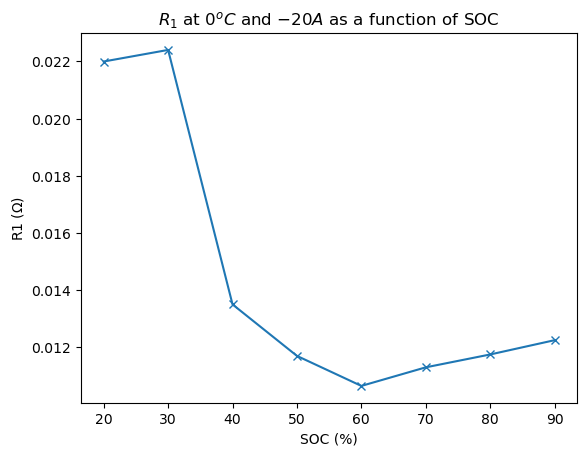

In [31]:
idx_20 = np.where(np.abs(I_peaks[0, 0]-(20)) < 0.01)[0][0]
SOC_plot = np.arange(0.9, 0.1, -0.1)
R1_plot = R1_tab[0, :, idx_20]

plt.plot(SOC_plot*100, R1_plot, '-x')
plt.xlabel('SOC (%)')
plt.ylabel('R1 ($\Omega$)')
plt.title('$R_1$ at $0^oC$ and $-20A$ as a function of SOC')
plt.show()

Plot the value for $R_1$ at different SOC and $-20A$ as a function of temperature.

In [32]:
idx_20 = np.where(np.abs(I_peaks[0, 0]-(20)) < 0.01)[0][0]
T0 = 20
E = read_fit_res(fit_res_dir, 'R1_arr')

In [33]:
R1_T0 = R1_tab[1, 6, idx_20]
def Arrhenius_30(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

R1_T0 = R1_tab[1, 3, idx_20]
def Arrhenius_60(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

R1_T0 = R1_tab[1, 0, idx_20]
def Arrhenius_90(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

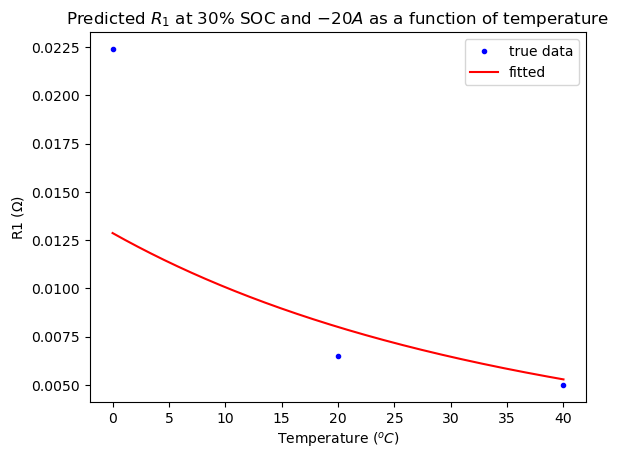

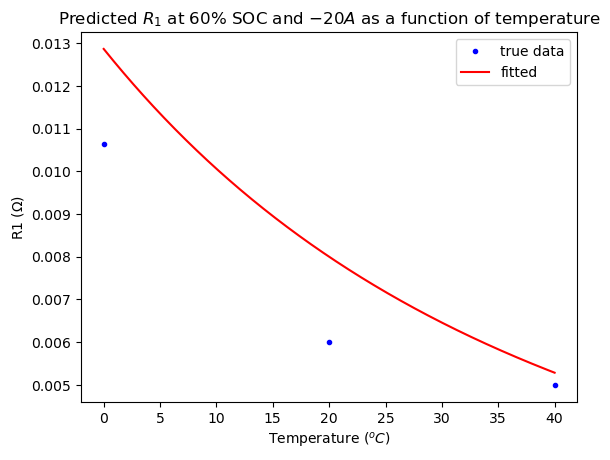

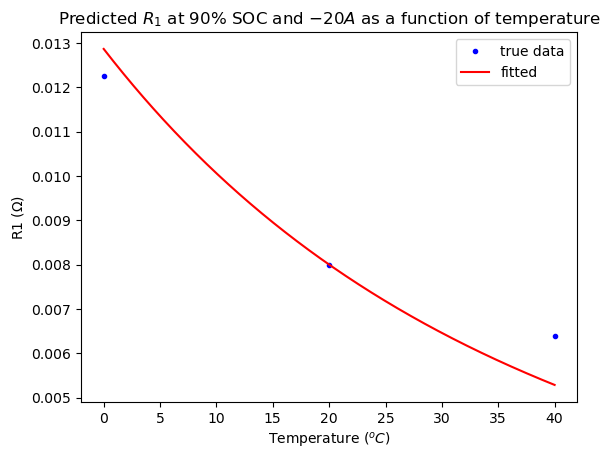

In [34]:
T_fit = [0, 20, 40]
T_plot = np.linspace(np.min(T_fit), np.max(T_fit), 500)

R1_true_30 = R1_tab[:, 6, idx_20]
R1_pred_30 = Arrhenius_30(T_plot, E)

R1_true_60 = R1_tab[:, 3, idx_20]
R1_pred_60 = Arrhenius_60(T_plot, E)

R1_true_90 = R1_tab[:, 0, idx_20]
R1_pred_90 = Arrhenius_90(T_plot, E)

plt.plot(T_fit, R1_true_30, 'b.', label='true data')
plt.plot(T_plot, R1_pred_30, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $30\%$ SOC and $-20A$ as a function of temperature')
plt.show()

plt.plot(T_fit, R1_true_60, 'b.', label='true data')
plt.plot(T_plot, R1_pred_60, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $60\%$ SOC and $-20A$ as a function of temperature')
plt.show()

plt.plot(T_fit, R1_true_90, 'b.', label='true data')
plt.plot(T_plot, R1_pred_90, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $90\%$ SOC and $-20A$ as a function of temperature')
plt.show()